In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def simulate_death_rate_data(n_cells=50, n_periods=100, true_lambda=0.001, excess_zeros_prob=0.80, random_seed=42):
    """
    Simulate death rate data for a given number of cells over multiple time periods.

    Parameters:
    n_cells (int): Number of grid cells to simulate.
    n_periods (int): Number of time periods to simulate.
    true_lambda (float): True mean death rate per person.
    excess_zeros_prob (float): Probability of excess zeros in the data.
    random_seed (int): Random seed for reproducibility.

    Returns:
    pd.DataFrame: A DataFrame containing simulated death rate data with columns:
                  'cell_id', 'time_period', 'population', 'deaths', 'death_rate'.
    """
    np.random.seed(random_seed)

    # Calculate total observations
    total_observations = n_cells * n_periods

    # Simulate population data for each cell
    population = np.random.randint(1000, 10000, size=n_cells)
    population = np.repeat(population, n_periods)  # Repeat population for each time period

    # Simulate death counts with excess zeros for each cell over time periods
    death_counts = np.random.negative_binomial(true_lambda * population, 0.5)
    excess_zeros = np.random.binomial(1, excess_zeros_prob, size=total_observations)
    death_counts = death_counts * (1 - excess_zeros)

    # Create a DataFrame
    data = pd.DataFrame({
        'cell_id': np.tile(np.arange(n_cells), n_periods),
        'time_id': np.repeat(np.arange(n_periods), n_cells),
        'population': population,
        'deaths': death_counts
    })

    # Calculate death rates
    data['death_rate'] = data['deaths'] / data['population']

    return data


In [4]:
def create_ecdf_eccdf_df(data):
    """
    Create a DataFrame with (empiric) CDF and (empiric) CCDF values for the given death rates.

    Parameters:
    data (pd.DataFrame): DataFrame containing the death rate data with columns 'cell_id', 'time_period', 'population', 'deaths', and 'death_rate'.

    Returns:
    pd.DataFrame: DataFrame containing the original data along with CDF and CCDF values.
    """
    # Sort the data by death rates
    sorted_data = data.sort_values('death_rate')

    # Calculate Empirical CDF
    cdf = np.arange(1, len(sorted_data['death_rate']) + 1) / len(sorted_data['death_rate'])

    # Calculate CCDF
    ccdf = 1.0 - cdf

    # Add CDF and CCDF to the sorted data
    sorted_data['cdf'] = cdf
    sorted_data['ccdf'] = ccdf

    return sorted_data

In [5]:
def calculate_cell_return_periods(data):
    """
    Calculate the cell-specific return periods for each death rate in the DataFrame.

    Parameters:
    data (pd.DataFrame): DataFrame containing the death rate data with columns 'cell_id', 'death_rate', 'cdf', and 'ccdf'.

    Returns:
    pd.DataFrame: Original DataFrame with an added column 'cell_return_period'.
    
    Example:
    If a cell in a row has a return period of 5, it means that the specific death rate in that row is expected to be exceeded once every 5 cells, on average.
    """
    # Calculate the return period for each row based on its own death rate
    def get_return_period(row):
        death_rate = row['death_rate']
        idx_more = np.searchsorted(data['death_rate'], death_rate, side='left')
        prob_specific_rate_or_more = data['ccdf'].iloc[idx_more] if idx_more < len(data) else 0.0

        # if prob_specific_rate_or_more is 0, set to low number
        if prob_specific_rate_or_more == 0:
            prob_specific_rate_or_more = np.exp(-100)
    
        return 1 / prob_specific_rate_or_more # why inf? because the rate is so low that it is not expected to be exceeded in the dataset

    # Apply the return period calculation for each row in the DataFrame
    data['cell_return_period'] = data.apply(get_return_period, axis=1)

    return data

In [6]:
# example usage
data = simulate_death_rate_data(n_cells=50, n_periods=100, true_lambda=0.001, excess_zeros_prob=0.80, random_seed=42)
data = create_ecdf_eccdf_df(data)
data = calculate_cell_return_periods(data)

data.sample(10, random_state=40)

,cell_id,time_id,population,deaths,death_rate,cdf,ccdf,cell_return_period
852,2,17,6578,2,0.000304,0.8178,0.1822,5.482456
4242,42,84,8041,0,0.000000,0.4162,0.5838,1.000200
3105,5,62,8734,0,0.000000,0.0084,0.9916,1.000200
2395,45,47,8849,0,0.000000,0.1594,0.8406,1.000200
3571,21,71,4890,0,0.000000,0.0710,0.9290,1.000200
4231,31,84,8041,4,0.000497,0.8368,0.1632,6.119951
2428,28,48,3047,2,0.000656,0.8586,0.1414,7.022472
1251,1,25,7949,0,0.000000,0.4694,0.5306,1.000200
887,37,17,6578,0,0.000000,0.5530,0.4470,1.000200
4631,31,92,1775,4,0.002254,0.9900,0.0100,98.039216


In [7]:
# Give me the percentiles of the return periods
data['cell_return_period'].describe(percentiles=[0.01, 0.05, 0.20, 0.50, 0.95, 0.99])

count    5.000000e+03
mean     5.376234e+39
std      3.801572e+41
min      1.000200e+00
1%       1.000200e+00
5%       1.000200e+00
20%      1.000200e+00
50%      1.000200e+00
95%      1.992032e+01
99%      9.807923e+01
max      2.688117e+43
Name: cell_return_period, dtype: float64

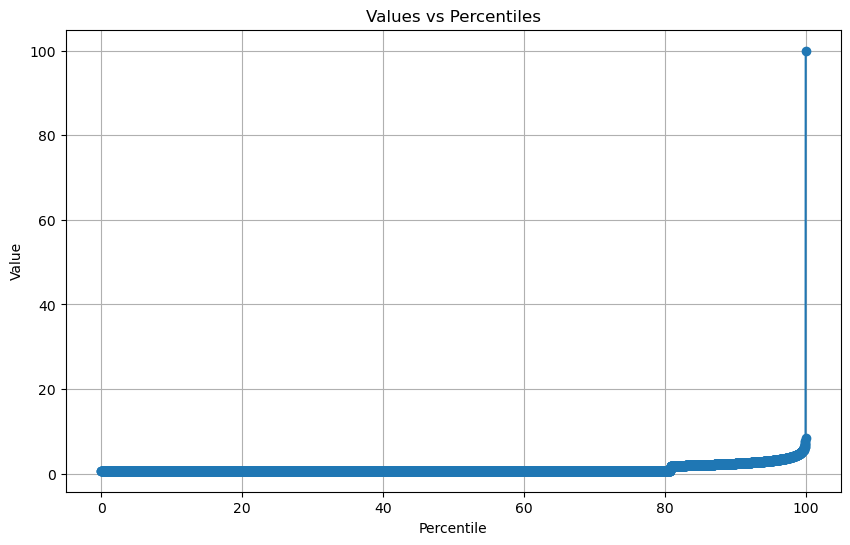

In [25]:
def plot_percentiles_vs_values(data, title='Values vs Percentiles', xlabel='Percentile', ylabel='Value', show_grid=True):
    """
    Plots the relationship between percentiles and values for a given dataset.
    
    Parameters:
    data (array-like): The dataset to analyze.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    show_grid (bool): Whether to show the grid on the plot.
    
    Returns:
    None
    """
    # Ensure data is a numpy array
    data = np.asarray(data)
    
    step = 0.02
    p_range = np.arange(0, 100 + step, step)

    # Calculate percentiles
    percentiles = np.percentile(data, p_range)
    
    # Plotting the values against their percentiles
    plt.figure(figsize=(10, 6))
    plt.plot(p_range, percentiles, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if show_grid:
        plt.grid(True)
    plt.show()

# Example usage
# Sample data
plot_percentiles_vs_values(np.log(data['cell_return_period']+1))
